In [535]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.parse, re
import matplotlib

# from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.impute import KNNImputer

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier

In [536]:
df = pd.read_csv("raw_data.csv", low_memory=False)
df = df.drop(df[df["Type"]=="house group"].index)
df = df.drop(df[df["Type"]=="apartment group"].index)

In [537]:
df = df[df["Type"]=="house"]

print("house_df shape: ",df.shape)
for i in df.columns:
    print(i, (40-len(i))*"-", df[i].isna().sum())

house_df shape:  (9822, 129)
id -------------------------------------- 0
Available as of ------------------------- 4652
Construction year ----------------------- 3329
Building condition ---------------------- 1059
Street frontage width ------------------- 5817
Number of frontages --------------------- 1185
Covered parking spaces ------------------ 4460
Outdoor parking spaces ------------------ 5423
Surroundings type ----------------------- 5854
Living area ----------------------------- 289
Living room surface --------------------- 4042
Dining room ----------------------------- 7095
How many fireplaces? -------------------- 8965
Kitchen type ---------------------------- 1971
Kitchen surface ------------------------- 4377
Bedrooms -------------------------------- 69
Bedroom 1 surface ----------------------- 3734
Bedroom 2 surface ----------------------- 3864
Bedroom 3 surface ----------------------- 4771
Bedroom 4 surface ----------------------- 7050
Bedroom 5 surface -------------------

In [538]:
df = df[['id','Price','Zip','Type','Subtype','location',
       'Surroundings type',
       'Living area','Surface of the plot',
       'Bedrooms','Kitchen type','Bathrooms',
       'Building condition',
       'Construction year', 
       'Number of frontages',
       'Covered parking spaces', 'Outdoor parking spaces', 
       'Swimming pool',
       'Furnished',
       'How many fireplaces?',
       'Terrace','Terrace surface',
       'Garden','Garden surface',
       'Primary energy consumption','Energy class','Heating type'
       ]]

In [539]:
df.groupby("Surroundings type")["Price"].max()

Surroundings type
Concrete                                      500000
Countryside                                  9999999
Fitted out                                    995000
Isolated                                      995000
Landscape                                     975000
Living area (residential, urban or rural)     999000
Mall                                           99000
Shop street                                   785000
Urban                                          99900
Name: Price, dtype: object

In [540]:
df = df.rename(columns={
    'location' :'Locality',
    'Transaction Type' : 'Type of sale',
    'Type' :'Type of property',
    'Subtype' : 'Subtype of property',
    'Number of frontages': 'Number of facades',
    'Bedrooms':'Number of rooms',
    'Surface of the plot' :'Surface of the land',
    'Kitchen type' : 'Fully equipped kitchen',
    'How many fireplaces?' : 'Open fire',
})
 

In [541]:
def clean_and_convert(column):
    column = column.apply(lambda x: re.sub('\D+', '', str(x)))
    column = column.replace('', np.nan)
    return column

In [542]:
df['Living area'] = clean_and_convert(df['Living area'])
df['Terrace surface'] = clean_and_convert(df['Terrace surface'])
df['Garden surface'] = clean_and_convert(df['Garden surface'])
df['Surface of the land'] = clean_and_convert(df['Surface of the land'])

df['Primary energy consumption'] = clean_and_convert(df['Primary energy consumption'])

df['Locality'] = df['Locality'].apply(urllib.parse.unquote)

In [543]:
df['Primary energy consumption']

0       335
1       480
2       157
3       304
4       252
       ... 
9983    383
9984    310
9985    527
9986    NaN
9987     96
Name: Primary energy consumption, Length: 9822, dtype: object

In [544]:
conditions = [
    (df['Garden']== "Yes"),
    (df["Garden"].isna()) & (df["Garden surface"].isna()),
    (df["Garden surface"].notna())
    ]
values = [1, 0, 1]
df['Garden'] = np.select(conditions, values)

df.loc[(df["Garden"] == 0 ) & (df["Garden surface"].isna()), 'Garden surface'] = 0

In [545]:
conditions = [
    (df['Terrace']== "Yes"),
    (df["Terrace"].isna()) & (df["Terrace surface"].isna()),
    (df["Terrace surface"].notna())
    ]
values = [1, 0, 1]
df['Terrace'] = np.select(conditions, values)

df.loc[(df["Terrace"] == 0 ) & (df["Terrace surface"].isna()), 'Terrace surface'] = 0

In [546]:
def nan_replacement(column):
    column = column.replace("Yes",1)
    column = column.replace("No",0)
    column = column.replace('', np.nan).fillna(0)
    return column

df['Furnished'] = nan_replacement(df['Furnished'])
df['Swimming pool'] = nan_replacement(df['Swimming pool'])
df['Open fire'] = nan_replacement(df['Open fire'])

In [547]:
# Mapping dictionary for replacing values in the "kitchen" column
kitchen_mapping = {
    # np.nan: -1,
    'Not installed': 0,
    'Installed': 1,
    'Semi equipped': 2,
    'Hyper equipped': 3,
    'USA uninstalled' :0,
    'USA installed': 1,
    'USA semi equipped': 2,
    'USA hyper equipped' :3
}
# Replace values in the "Kitchen type" column with corresponding numbers and create a new column called "Kitchen values"
df['Kitchen values'] = df['Fully equipped kitchen'].map(kitchen_mapping).fillna(df['Fully equipped kitchen'])

building_cond_mapping = {
    # np.nan: -1,
    'To restore': 0,
    'To be done up': 2,
    'Just renovated': 3,
    'To renovate': 1,
    'Good': 3,
    'As new' :4
}

df['Building Cond. values'] = df['Building condition'].map(building_cond_mapping).fillna(df['Building condition'])

df = df.loc[:, ~df.columns.isin(['Fully equipped kitchen','Building condition'])]

In [548]:
df = df.drop(df[df["Living area"].isna()].index)
df = df.drop(df[df["Surface of the land"].isna()].index)

In [549]:
conditions = [
    (df["Covered parking spaces"].notna()) & (df["Outdoor parking spaces"].notna()),
    (df["Covered parking spaces"].isna()) & (df["Outdoor parking spaces"].isna()),
    (df["Covered parking spaces"].isna()) & (df["Outdoor parking spaces"].notna()),
    (df["Covered parking spaces"].notna()) & (df["Outdoor parking spaces"].isna())
    ]
values = [(df["Covered parking spaces"]+df["Outdoor parking spaces"]), 0, df["Outdoor parking spaces"],df["Covered parking spaces"]]
df['Parking'] = np.select(conditions, values)

In [550]:
def get_province(zip_code):
    if 1000 <= zip_code <= 1299:
        return 'Brussels Capital Region'
    elif 1300 <= zip_code <= 1499:
        return 'Walloon Brabant'
    elif 1500 <= zip_code <= 1999 or 3000 <= zip_code <= 3499:
        return 'Flemish Brabant'
    elif 2000 <= zip_code <= 2999:
        return 'Antwerp'
    elif 3500 <= zip_code <= 3999:
        return 'Limburg'
    elif 4000 <= zip_code <= 4999:
        return 'Liège'
    elif 5000 <= zip_code <= 5999:
        return 'Namur'
    elif 6000 <= zip_code <= 6599 or 7000 <= zip_code <= 7999:
        return 'Hainaut'
    elif 6600 <= zip_code <= 6999:
        return 'Luxembourg'
    elif 8000 <= zip_code <= 8999:
        return 'West Flanders'
    elif 9000 <= zip_code <= 9999:
        return 'East Flanders'
    else:
        return 'Unknown'
        
df['Province'] = df['Zip'].apply(get_province)

In [551]:
df = df.loc[:, ~df.columns.isin(["Covered parking spaces","Outdoor parking spaces"])]

In [552]:
print(df.shape)
df.isna().sum()

(9043, 27)


id                               0
Price                            0
Zip                              0
Type of property                 0
Subtype of property              0
Locality                         0
Surroundings type             5293
Living area                      0
Surface of the land              0
Number of rooms                 53
Bathrooms                     1109
Construction year             2980
Number of facades             1086
Swimming pool                    0
Furnished                        0
Open fire                        0
Terrace                          0
Terrace surface               2737
Garden                           0
Garden surface                1537
Primary energy consumption     696
Energy class                     0
Heating type                  1359
Kitchen values                1831
Building Cond. values          935
Parking                          0
Province                         0
dtype: int64

In [553]:
df = df.astype({"Price":"float",
                "Number of rooms":"float",
                "Living area":"float",
                "Terrace surface":"float",
                "Garden surface":"float",
                "Surface of the land":"float",
                "Number of facades":"float",
                "Primary energy consumption":"float"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9043 entries, 0 to 9987
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9043 non-null   int64  
 1   Price                       9043 non-null   float64
 2   Zip                         9043 non-null   int64  
 3   Type of property            9043 non-null   object 
 4   Subtype of property         9043 non-null   object 
 5   Locality                    9043 non-null   object 
 6   Surroundings type           3750 non-null   object 
 7   Living area                 9043 non-null   float64
 8   Surface of the land         9043 non-null   float64
 9   Number of rooms             8990 non-null   float64
 10  Bathrooms                   7934 non-null   float64
 11  Construction year           6063 non-null   float64
 12  Number of facades           7957 non-null   float64
 13  Swimming pool               9043 non-n

In [554]:
housedf = df.copy()

print("House DataFrame shape (before): ",housedf.shape)
print("House data min (with outliers): ",housedf['Price'].min())
print("House data max (with outliers): ",housedf['Price'].max())

from typing import List
# Remove outliers
def remove_outliers(df: pd.DataFrame, columns: List[str], n_std: int) -> pd.DataFrame:
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

new_housedf = remove_outliers(housedf, ['Price'], 4)

print("_"*30)
print("House DataFrame shape (after removing): ",new_housedf.shape)
print("House data min (without outliers): ", new_housedf['Price'].min())
print("House data max (without outliers): ", new_housedf['Price'].max())

House DataFrame shape (before):  (9043, 27)
House data min (with outliers):  2500.0
House data max (with outliers):  11000000.0
Working on column: Price
______________________________
House DataFrame shape (after removing):  (8935, 27)
House data min (without outliers):  2500.0
House data max (without outliers):  3100000.0


In [555]:
new_housedf.columns

Index(['id', 'Price', 'Zip', 'Type of property', 'Subtype of property',
       'Locality', 'Surroundings type', 'Living area', 'Surface of the land',
       'Number of rooms', 'Bathrooms', 'Construction year',
       'Number of facades', 'Swimming pool', 'Furnished', 'Open fire',
       'Terrace', 'Terrace surface', 'Garden', 'Garden surface',
       'Primary energy consumption', 'Energy class', 'Heating type',
       'Kitchen values', 'Building Cond. values', 'Parking', 'Province'],
      dtype='object')

In [556]:
print(new_housedf.shape)
house_df = remove_outliers(new_housedf, ['Living area','Surface of the land'], 3)
print(house_df.shape)

(8935, 27)
Working on column: Living area
Working on column: Surface of the land
(8869, 27)


In [557]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8869 entries, 0 to 9987
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          8869 non-null   int64  
 1   Price                       8869 non-null   float64
 2   Zip                         8869 non-null   int64  
 3   Type of property            8869 non-null   object 
 4   Subtype of property         8869 non-null   object 
 5   Locality                    8869 non-null   object 
 6   Surroundings type           3709 non-null   object 
 7   Living area                 8869 non-null   float64
 8   Surface of the land         8869 non-null   float64
 9   Number of rooms             8818 non-null   float64
 10  Bathrooms                   7774 non-null   float64
 11  Construction year           5925 non-null   float64
 12  Number of facades           7801 non-null   float64
 13  Swimming pool               8869 non-n

In [558]:
house_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8869.0,1.046547e+07,163342.637732,8373923.0,10423860.0,10519106.0,10566849.0,10597410.0
Price,8869.0,4.917861e+05,412795.546609,2500.0,255000.0,375000.0,569000.0,3100000.0
Zip,8869.0,5.069579e+03,2989.496081,1000.0,2018.0,4520.0,8210.0,9991.0
Living area,8869.0,2.243935e+02,135.041606,23.0,145.0,189.0,260.0,2272.0
Surface of the land,8869.0,9.335360e+02,1560.875779,1.0,204.0,450.0,983.0,16254.0
Number of rooms,8818.0,3.756181e+00,1.586556,1.0,3.0,3.0,4.0,25.0
Bathrooms,7774.0,1.605223e+00,1.214085,1.0,1.0,1.0,2.0,25.0
Construction year,5925.0,1.959536e+03,42.779232,1755.0,1932.0,1965.0,1991.0,2025.0
Number of facades,7801.0,2.999744e+00,0.876766,1.0,2.0,3.0,4.0,10.0
Swimming pool,8869.0,4.498816e-02,0.207290,0.0,0.0,0.0,0.0,1.0


In [559]:
def one_convert_to_nan(column):
    column = column.replace(1.0, np.nan)
    return column

house_df['Surface of the land'] = one_convert_to_nan(house_df['Surface of the land'])

In [560]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8869 entries, 0 to 9987
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          8869 non-null   int64  
 1   Price                       8869 non-null   float64
 2   Zip                         8869 non-null   int64  
 3   Type of property            8869 non-null   object 
 4   Subtype of property         8869 non-null   object 
 5   Locality                    8869 non-null   object 
 6   Surroundings type           3709 non-null   object 
 7   Living area                 8869 non-null   float64
 8   Surface of the land         8864 non-null   float64
 9   Number of rooms             8818 non-null   float64
 10  Bathrooms                   7774 non-null   float64
 11  Construction year           5925 non-null   float64
 12  Number of facades           7801 non-null   float64
 13  Swimming pool               8869 non-n

In [561]:
knn_df = house_df.loc[:, ~house_df.columns.isin(["Price","Type of property","Subtype of property","Locality","Surroundings type","Energy class","Heating type","Province"])]
other = ['id', 'Zip', 'Living area', 'Surface of the land', 'Number of rooms',
       'Bathrooms', 'Construction year', 'Number of facades', 'Swimming pool',
       'Furnished', 'Open fire', 'Terrace', 'Terrace surface', 'Garden',
       'Garden surface', 'Kitchen values', 'Building Cond. values', 'Parking',"Primary energy consumption",]

impute_knn = KNNImputer(n_neighbors=5)

knn_df = impute_knn.fit_transform(knn_df).astype(float)

#Creating dfs with missing values filled in 
imputed_houses = pd.DataFrame(knn_df, columns= other)

#Creating dfs with prices
new_houses = house_df[['id',"Price","Type of property","Subtype of property","Locality","Surroundings type","Energy class","Heating type","Province"]]

#Merging dfs (with prices and without prices (with other values filled in))
complete_houses = pd.merge(new_houses, imputed_houses,on='id')


In [562]:
complete_houses.isna().sum()


id                               0
Price                            0
Type of property                 0
Subtype of property              0
Locality                         0
Surroundings type             5160
Energy class                     0
Heating type                  1329
Province                         0
Zip                              0
Living area                      0
Surface of the land              0
Number of rooms                  0
Bathrooms                        0
Construction year                0
Number of facades                0
Swimming pool                    0
Furnished                        0
Open fire                        0
Terrace                          0
Terrace surface                  0
Garden                           0
Garden surface                   0
Kitchen values                   0
Building Cond. values            0
Parking                          0
Primary energy consumption       0
dtype: int64

In [563]:
complete_houses.to_csv("final_house.csv")

In [564]:
new_df = complete_houses[['id', 'Price', 'Zip', 
       'Living area', 'Surface of the land',
       'Number of rooms', 'Bathrooms', 'Construction year',
       'Number of facades', 'Swimming pool', 'Furnished', 'Open fire',
       'Terrace', 'Terrace surface', 'Garden', 'Garden surface',
       'Kitchen values', 'Building Cond. values', 'Parking']]

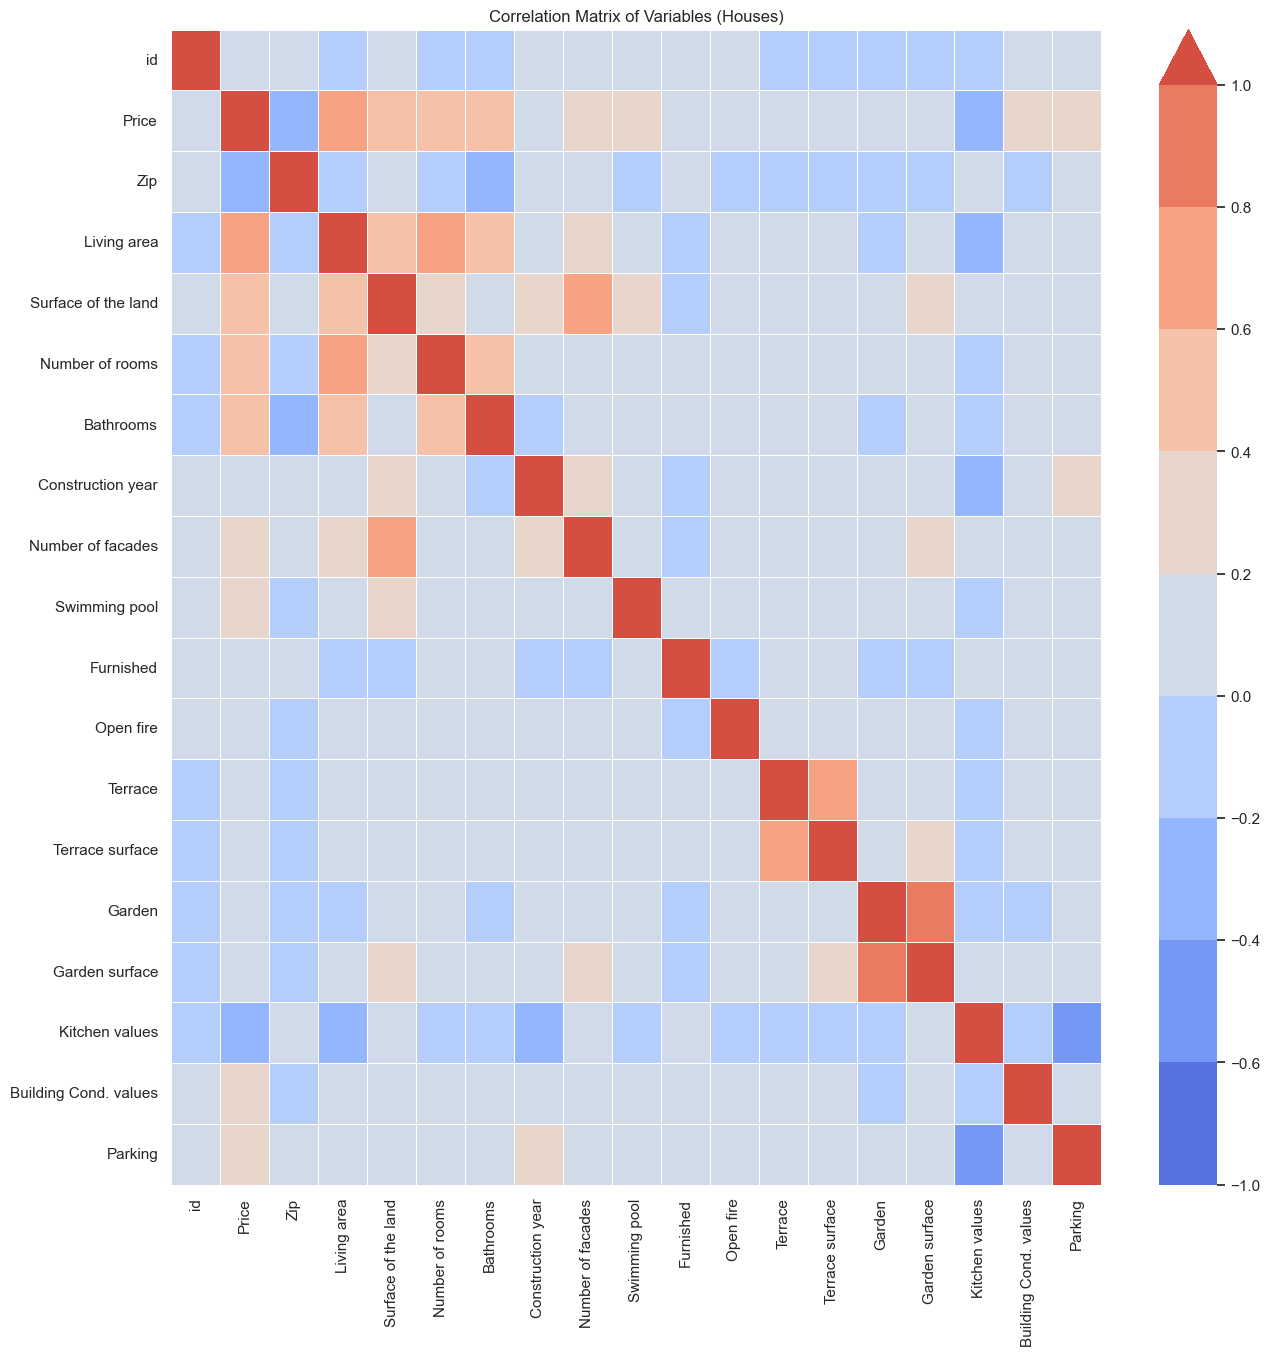

In [565]:
corr_matrix = new_df.corr(method='spearman')
colors = sns.color_palette('coolwarm', 10)
levels = [-1.0, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend="max")
sns.heatmap(corr_matrix, cmap = cmap, linewidths=.5, norm=norm)

plt.title('Correlation Matrix of Variables (Houses)')
sns.set (rc = {'figure.figsize':(15, 15)})
plt.show()